# Laboratorio 06 - Análisis de redes sociales

### Problema 01: @TráficoGT

In [33]:
import pandas as pd
import unicodedata
import string
import nltk
import re
from nltk.corpus import stopwords
from collections import Counter

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import networkx as nx

import community as community_louvain 
import collections

import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import json
from datetime import datetime
import seaborn as sns

### Carga de datos

In [34]:
def load_twitter_data(file_path):
    """
    Carga datos de Twitter removiendo BOM y caracteres problemáticos
    """
    tweets = []
    
    with open(file_path, 'r', encoding='utf-16') as file:  # Cambio a utf-16 por el BOM
        for line_num, line in enumerate(file, 1):
            line = line.strip()
            
            # Saltar líneas vacías
            if not line:
                continue
                
            # Remover BOM si existe al inicio de la línea
            if line.startswith('\ufeff'):
                line = line[1:]
            
            try:
                tweet = json.loads(line)
                tweets.append(tweet)
            except json.JSONDecodeError as e:
                if line_num <= 5:  
                    print(f"Error en línea {line_num}: {str(e)[:50]}...")
                continue
    
    return tweets

In [35]:
def create_dataframe(tweets):
    """
    Convierte los tweets a DataFrame
    """
    data = []
    
    for tweet in tweets:
        data.append({
            'id': tweet.get('id_str'),
            'fecha': tweet.get('date'),
            'usuario': tweet.get('user', {}).get('username'),
            'nombre_completo': tweet.get('user', {}).get('displayname'),
            'contenido': tweet.get('rawContent'),
            'retweets': tweet.get('retweetCount', 0),
            'likes': tweet.get('likeCount', 0),
            'respuestas': tweet.get('replyCount', 0),
            'citas': tweet.get('quoteCount', 0),
            'vistas': tweet.get('viewCount', 0),
            'idioma': tweet.get('lang')
        })
    
    return pd.DataFrame(data)

In [36]:
file_path = 'traficogt.txt'
tweets_data = load_twitter_data(file_path)
df = create_dataframe(tweets_data)

print(f"Datos cargados: {len(df)} tweets")

Datos cargados: 5604 tweets


### Inspección Inicial

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5604 entries, 0 to 5603
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               5604 non-null   object 
 1   fecha            5604 non-null   object 
 2   usuario          5604 non-null   object 
 3   nombre_completo  5604 non-null   object 
 4   contenido        5604 non-null   object 
 5   retweets         5604 non-null   int64  
 6   likes            5604 non-null   int64  
 7   respuestas       5604 non-null   int64  
 8   citas            5604 non-null   int64  
 9   vistas           5600 non-null   float64
 10  idioma           5604 non-null   object 
dtypes: float64(1), int64(4), object(6)
memory usage: 481.7+ KB


In [38]:
display(df.head())

,id,fecha,usuario,nombre_completo,contenido,retweets,likes,respuestas,citas,vistas,idioma
0,1834236045598056867,2024-09-12 14:22:06+00:00,traficogt,traficoGT,Es comprensible la resolución... El ruso sabe de engrasar maquinaria.,0,1,0,0,393.0,es
1,1834029142565658846,2024-09-12 00:39:56+00:00,monymmorales,Mony,"La corrupción de la @CC_Guatemala\nes descarada, falsificación de documentos y obligaron a extenderles DPI.\nhttps://t.co/0J24ZCXJ2c",56,84,0,4,1587.0,es
2,1834039491826180424,2024-09-12 01:21:04+00:00,animaldgalaccia,Jairo De La Nada,@PNCdeGuatemala @mingobguate @FJimenezmingob @diegoedeleon @amilcarmontejo @traficogt \n\n🚨🚨🚨🚨🚨,0,1,0,0,91.0,qme
3,1833963729136091179,2024-09-11 20:20:01+00:00,EstacionDobleA,Estación Doble A,@amilcarmontejo @AztecaNoticiaGT @BancadaSemilla @BArevalodeLeon @diputadojp @EmisorasUnidas @eP_investiga @ImpactoNoticiGT @lahoragt @mingobguate @PrensaComunitar @Transito_mixco @DGTguate @PMT_VILLANUEVA @InfoTransitoGt @traficogt @PMT_SanJuanSac @PMTSanLucasSac @YenerPlaza,0,0,0,0,46.0,qam
4,1833665391698092330,2024-09-11 00:34:31+00:00,CubReserva,CUB Reserva Kanajuyu Z 16,"@soy_502 @AztecaNoticiaGT @CONAPgt @DenunciaEMPAGUA @muniguate @GuatemalaGob @Guatevision_tv @pattyo502 @karinapazGt @Josechic86 @vecinosz16 URGENTE zona 16 en deterioro por tala inmoderada, el tráfico es desesperante @traficogt @EmisorasUnidas @eP_investiga @IsaPaiz_",0,1,0,0,171.0,es


In [39]:
display(df.tail())

,id,fecha,usuario,nombre_completo,contenido,retweets,likes,respuestas,citas,vistas,idioma
5599,1711138940990722120,2023-10-08 21:58:09+00:00,guiselabarrios,Guisela Barrios,"@traficogt Y no que presentando 5 mil firmas ante el Congrueso de ratas, si procedería la destitución de la “comosiama”.",0,0,0,0,8.0,es
5600,1711133805182869820,2023-10-08 21:37:45+00:00,mvtrooper,Eduardo Marroquín,@hshetemul @traficogt Y de igual Manera quitan el derecho de repuesta al pueblo en sus publicaciones al Estilo del corrupto @MPguatemala!\n\nSin ninguna duda son parte de este sistema podrido @CangGuatemala,0,0,0,0,3.0,es
5601,1711133697552810362,2023-10-08 21:37:19+00:00,elmeronene1,elmeronene,@traficogt Es algo más fuerte que ellos no quieren que se sepa por eso es que no renuncian,0,0,0,0,21.0,es
5602,1711132207631212797,2023-10-08 21:31:24+00:00,mvtrooper,Eduardo Marroquín,@Factor4_GT @traficogt @CC_Guatemala @MPguatemala https://t.co/o2bCGkJiEU,0,0,0,0,4.0,qme
5603,1711127715741417476,2023-10-08 21:13:33+00:00,91072dff5a5a4f1,Helmuttt,@AgenciaOcote @traficogt Vieja ignorante,0,0,0,0,17.0,es


### Limpieza y Preprocesamiento de datos

In [40]:
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

SPANISH_STOPWORDS = set(stopwords.words('spanish'))

In [41]:
CUSTOM_STOPWORDS = {'q', 'asi', 'mas', 'jajaja', 'va', 'ahora', 'da', 'pasa', 'sera', 'siempre', 'ano', 'pue', 'bien', 'debe', 'nadie', 'hace', 'dice', 'vos', 'ir', 'cosa', 'paso', 'tan', 'pasa', 'sera', 'ver', 'hshetmul' }  
STOPWORDS = SPANISH_STOPWORDS.union(CUSTOM_STOPWORDS)

URL_RE = re.compile(r'https?://\S+|www\.\S+', re.IGNORECASE)
MENTION_RE = re.compile(r'@\w+')
HASHTAG_RE = re.compile(r'#\w+')
EMOJI_RE = re.compile(r'[\U00010000-\U0010ffff]', flags=re.UNICODE)

In [42]:
def normalize_username(u):
    """Normaliza nombres de usuario (minúsculas, sin espacios)."""
    if pd.isna(u):
        return u
    return str(u).strip().lower()

def clean_text(text: str):
    """Limpieza avanzada del texto del tweet."""
    if pd.isna(text):
        return ''
    t = text
    t = URL_RE.sub(' ', t)                          # Eliminar URLs
    t = EMOJI_RE.sub(' ', t)                        # Eliminar emojis
    t = t.lower()                                   # A minúsculas
    t = unicodedata.normalize('NFKD', t)            # Normalizar acentos
    t = ''.join(ch for ch in t if not unicodedata.combining(ch))
    t = t.translate(str.maketrans('', '', string.punctuation))  # Eliminar puntuación
    t = re.sub(r'\d+', ' ', t)                      # Eliminar números
    tokens = [w for w in re.findall(r'\b\w+\b', t) if w not in STOPWORDS]
    return ' '.join(tokens)

def extract_mentions(text: str):
    """Extrae menciones (@usuario)."""
    return [m.lower() for m in MENTION_RE.findall(text or '')]

def extract_hashtags(text: str):
    """Extrae hashtags (#tema)."""
    return [h.lower() for h in HASHTAG_RE.findall(text or '')]

def is_retweet(text: str):
    """Detecta si es retweet."""
    return bool(re.match(r'^\s*rt\s*@', str(text).lower()))

def is_reply(text: str):
    """Detecta si es reply (respuesta directa)."""
    return bool(re.match(r'^\s*@', str(text).lower()))


In [43]:
df['usuario'] = df['usuario'].map(normalize_username)
df['contenido_limpio'] = df['contenido'].map(clean_text)
df['menciones'] = df['contenido'].map(extract_mentions)
df['hashtags'] = df['contenido'].map(extract_hashtags)
df['is_retweet'] = df['contenido'].map(is_retweet)
df['is_reply'] = df['contenido'].map(is_reply)
df['fecha'] = pd.to_datetime(df['fecha'], errors='coerce')

df = df.drop_duplicates(subset=['usuario', 'contenido', 'fecha']).reset_index(drop=True)

pd.set_option("display.max_colwidth", None)
display(df[['usuario', 'contenido', 'contenido_limpio', 'menciones', 'hashtags']].head(10))

,usuario,contenido,contenido_limpio,menciones,hashtags
0,traficogt,Es comprensible la resolución... El ruso sabe de engrasar maquinaria.,comprensible resolucion ruso sabe engrasar maquinaria,[],[]
1,monymmorales,"La corrupción de la @CC_Guatemala\nes descarada, falsificación de documentos y obligaron a extenderles DPI.\nhttps://t.co/0J24ZCXJ2c",corrupcion ccguatemala descarada falsificacion documentos obligaron extenderles dpi,[@cc_guatemala],[]
2,animaldgalaccia,@PNCdeGuatemala @mingobguate @FJimenezmingob @diegoedeleon @amilcarmontejo @traficogt \n\n🚨🚨🚨🚨🚨,pncdeguatemala mingobguate fjimenezmingob diegoedeleon amilcarmontejo traficogt,"[@pncdeguatemala, @mingobguate, @fjimenezmingob, @diegoedeleon, @amilcarmontejo, @traficogt]",[]
3,estaciondoblea,@amilcarmontejo @AztecaNoticiaGT @BancadaSemilla @BArevalodeLeon @diputadojp @EmisorasUnidas @eP_investiga @ImpactoNoticiGT @lahoragt @mingobguate @PrensaComunitar @Transito_mixco @DGTguate @PMT_VILLANUEVA @InfoTransitoGt @traficogt @PMT_SanJuanSac @PMTSanLucasSac @YenerPlaza,amilcarmontejo aztecanoticiagt bancadasemilla barevalodeleon diputadojp emisorasunidas epinvestiga impactonoticigt lahoragt mingobguate prensacomunitar transitomixco dgtguate pmtvillanueva infotransitogt traficogt pmtsanjuansac pmtsanlucassac yenerplaza,"[@amilcarmontejo, @aztecanoticiagt, @bancadasemilla, @barevalodeleon, @diputadojp, @emisorasunidas, @ep_investiga, @impactonoticigt, @lahoragt, @mingobguate, @prensacomunitar, @transito_mixco, @dgtguate, @pmt_villanueva, @infotransitogt, @traficogt, @pmt_sanjuansac, @pmtsanlucassac, @yenerplaza]",[]
4,cubreserva,"@soy_502 @AztecaNoticiaGT @CONAPgt @DenunciaEMPAGUA @muniguate @GuatemalaGob @Guatevision_tv @pattyo502 @karinapazGt @Josechic86 @vecinosz16 URGENTE zona 16 en deterioro por tala inmoderada, el tráfico es desesperante @traficogt @EmisorasUnidas @eP_investiga @IsaPaiz_",aztecanoticiagt conapgt denunciaempagua muniguate guatemalagob guatevisiontv pattyo karinapazgt josechic vecinosz urgente zona deterioro tala inmoderada trafico desesperante traficogt emisorasunidas epinvestiga isapaiz,"[@soy_502, @aztecanoticiagt, @conapgt, @denunciaempagua, @muniguate, @guatemalagob, @guatevision_tv, @pattyo502, @karinapazgt, @josechic86, @vecinosz16, @traficogt, @emisorasunidas, @ep_investiga, @isapaiz_]",[]
5,alejandro2024gt,"@amilcarmontejo @PMTMuniGuate @Noti7Guatemala @NuestroDiario @T13Noticias @AztecaGuate @traficogt hay avenidas y calles (11 avenida 8 a la 12 calle) sin luz, semáforo y sin agentes de emetra .",amilcarmontejo pmtmuniguate noti guatemala nuestrodiario t noticias aztecaguate traficogt avenidas calles avenida calle luz semaforo agentes emetra,"[@amilcarmontejo, @pmtmuniguate, @noti7guatemala, @nuestrodiario, @t13noticias, @aztecaguate, @traficogt]",[]
6,julyponce21,Favor compartir \nEl vive el zona 7 Bethania \n@traficogt @amilcarmontejo @PNCdeGuatemala #urgente #Desaparecido https://t.co/LcIJv0Ffsj,favor compartir vive zona bethania traficogt amilcarmontejo pncdeguatemala urgente desaparecido,"[@traficogt, @amilcarmontejo, @pncdeguatemala]","[#urgente, #desaparecido]"
7,cubreserva,@traficogt @_ojoconmipisto @soy_502 @AztecaNoticiaGT @AztecaNoticiaGT @muniguate @CONAPgt @DenunciaEMPAGUA @EmisorasUnidas @eP_investiga @luisvengt @samuel_pz @Josechic86 @CiudadCayala @marnguate @karinapazGt @vecinosz16 es importante ponerle atención a los vecinos de z 16 https://t.co/vRDMtvj36F,traficogt ojoconmipisto aztecanoticiagt aztecanoticiagt muniguate conapgt denunciaempagua emisorasunidas epinvestiga luisvengt samuelpz josechic ciudadcayala marnguate karinapazgt vecinosz importante ponerle atencion vecinos z,"[@traficogt, @_ojoconmipisto, @soy_502, @aztecanoticiagt, @aztecanoticiagt, @muniguate, @conapgt, @denunciaempagua, @emisorasunidas, @ep_investiga, @luisvengt, @samuel_pz, @josechic86, @ciudadcayala, @marnguate, @karinapazgt, @vecinosz16]",[]
8,alexdel92022343,@piero_coen @FJimenezmingob @traficogt @mingobguate @PNCdeGuatemala @DiariodeCA @AGN_noticias @R

### Análisis Exploratorio

In [44]:
total_tweets = len(df)
usuarios_unicos = df['usuario'].nunique()
total_menciones = df['menciones'].map(len).sum()
total_hashtags = df['hashtags'].map(len).sum()
total_retweets = df['is_retweet'].sum()
total_respuestas = df['is_reply'].sum()

print("---Métricas generales---")
print(f"- Tweets totales: {total_tweets}")
print(f"- Usuarios únicos: {usuarios_unicos}")
print(f"- Total de menciones: {total_menciones}")
print(f"- Total de hashtags: {total_hashtags}")
print(f"- Total de retweets: {total_retweets}")
print(f"- Total de respuestas: {total_respuestas}")

---Métricas generales---
- Tweets totales: 5596
- Usuarios únicos: 2071
- Total de menciones: 11009
- Total de hashtags: 592
- Total de retweets: 0
- Total de respuestas: 4158


In [45]:
top_usuarios = df['usuario'].value_counts().head(10)
print("\nUsuarios más activos:")
print(top_usuarios)


Usuarios más activos:
usuario
traficogt          781
batallonjalapa     133
mildred_gaitan     103
lahoragt            72
chofito63569841     47
angeln8             46
prensacomunitar     40
hellboy17oc         39
papaabumario        36
alejandro2024gt     33
Name: count, dtype: int64


In [46]:
hashtags_flat = [h for sublist in df['hashtags'] for h in sublist]
top_hashtags = Counter(hashtags_flat).most_common(10)
print("\nHashtags más frecuentes:")
print(top_hashtags)


Hashtags más frecuentes:
[('#ahora', 30), ('#guatemala', 25), ('#ahoralh', 19), ('#urgente', 16), ('#traficogt', 16), ('#renunciengolpistas', 15), ('#lahoradeactualizarnos', 8), ('#guateresiste', 8), ('#paronacionalindefinido', 8), ('#paronacionaindefinido', 8)]


In [47]:
menciones_flat = [m for sublist in df['menciones'] for m in sublist]
top_menciones = Counter(menciones_flat).most_common(10)
print("\nUsuarios más mencionados:")
print(top_menciones)


Usuarios más mencionados:
[('@traficogt', 4239), ('@barevalodeleon', 433), ('@drgiammattei', 175), ('@amilcarmontejo', 166), ('@prensacomunitar', 162), ('@mpguatemala', 139), ('@mmendoza_gt', 131), ('@lahoragt', 128), ('@cc_guatemala', 110), ('@muniguate', 98)]


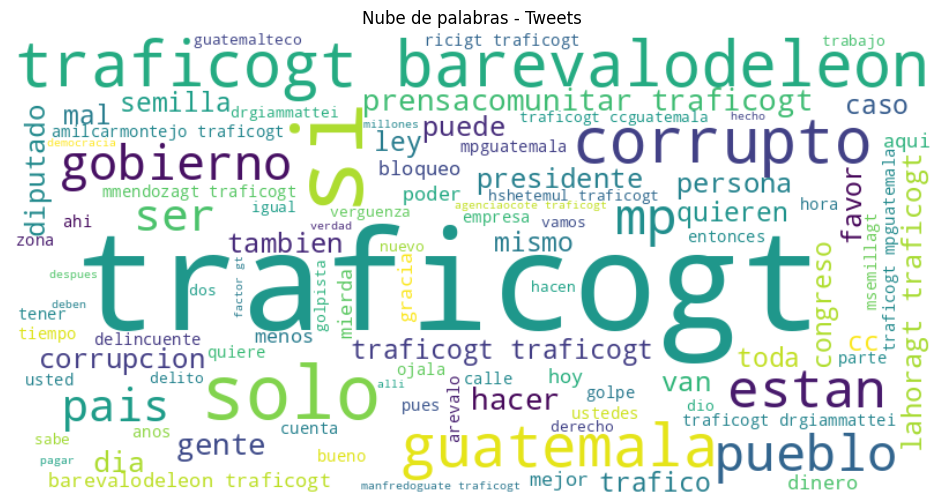

In [48]:
texto = ' '.join(df['contenido_limpio'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(texto)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Nube de palabras - Tweets")
plt.show()

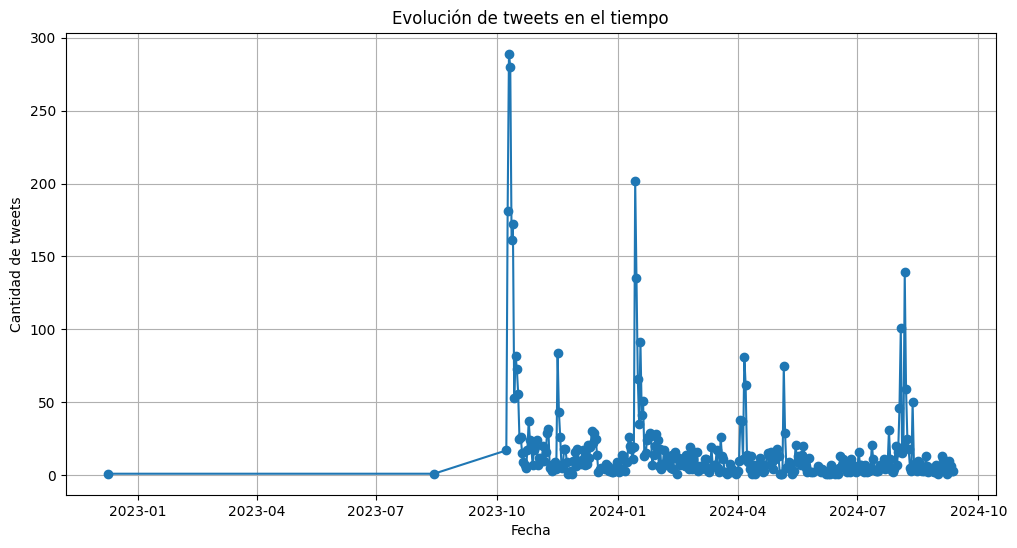

In [49]:
tweets_por_fecha = df.groupby(df['fecha'].dt.date).size()
plt.figure(figsize=(12,6))
tweets_por_fecha.plot(kind='line', marker='o')
plt.title("Evolución de tweets en el tiempo")
plt.ylabel("Cantidad de tweets")
plt.xlabel("Fecha")
plt.grid(True)
plt.show()

## Formulación de 3 preguntas:

### Pregunta 1:

**¿Qué usuarios son los más influyentes o activos en la conversación?**

**Análisis:**

* Según el `value_counts()` de usuarios, **@traficogt** lidera con diferencia el volumen de tweets, seguido por cuentas como `barevalodeleon`, `mpguatemala`, etc.
* Esto sugiere que **@traficogt** es una cuenta de noticias/tráfico muy citada y fuente principal de información.
* La concentración de tweets en pocos usuarios muestra un ecosistema donde **unas pocas cuentas dominan la conversación**.

**Conclusión:**
La red es altamente centralizada: pocas cuentas generan la mayoría del contenido y son puntos clave para entender tendencias y la propagación de información.

---

### Pregunta 2:

**¿Cuáles son los temas más frecuentes en los tweets?**

**Análisis:**

* La nube de palabras muestra términos recurrentes como **“gobierno”, “corrupción”, “Guatemala”, “pueblo”, “congreso”**.
* Los hashtags más usados (`#guatemala`, `#trafico`, etc.) refuerzan estos temas.
* Hay un fuerte componente de **crítica política y social** (corrupción, congreso) junto con información de tráfico (rol original de la cuenta principal).

**Conclusión:**
Los datos revelan que, aunque el dataset viene de una cuenta centrada en el tráfico, gran parte de la conversación está marcada por **temas políticos y sociales**, lo que puede indicar el papel de Twitter como canal de denuncia ciudadana.

---

### Pregunta 3:

**¿Existen picos claros de actividad en el tiempo? ¿Qué podrían indicar?**

**Análisis:**

* La gráfica temporal muestra **picos de tweets** alrededor de:

  * Octubre 2023 (\~280 tweets)
  * Enero 2024 (\~200 tweets)
  * Julio 2024 (\~140 tweets)
* Estos picos coinciden probablemente con **eventos importantes** (manifestaciones, bloqueos, noticias nacionales).


# Análisis de la topología de la red

### Construcción del Grafo de Interacciones

Nodos: 3091
Aristas: 7417


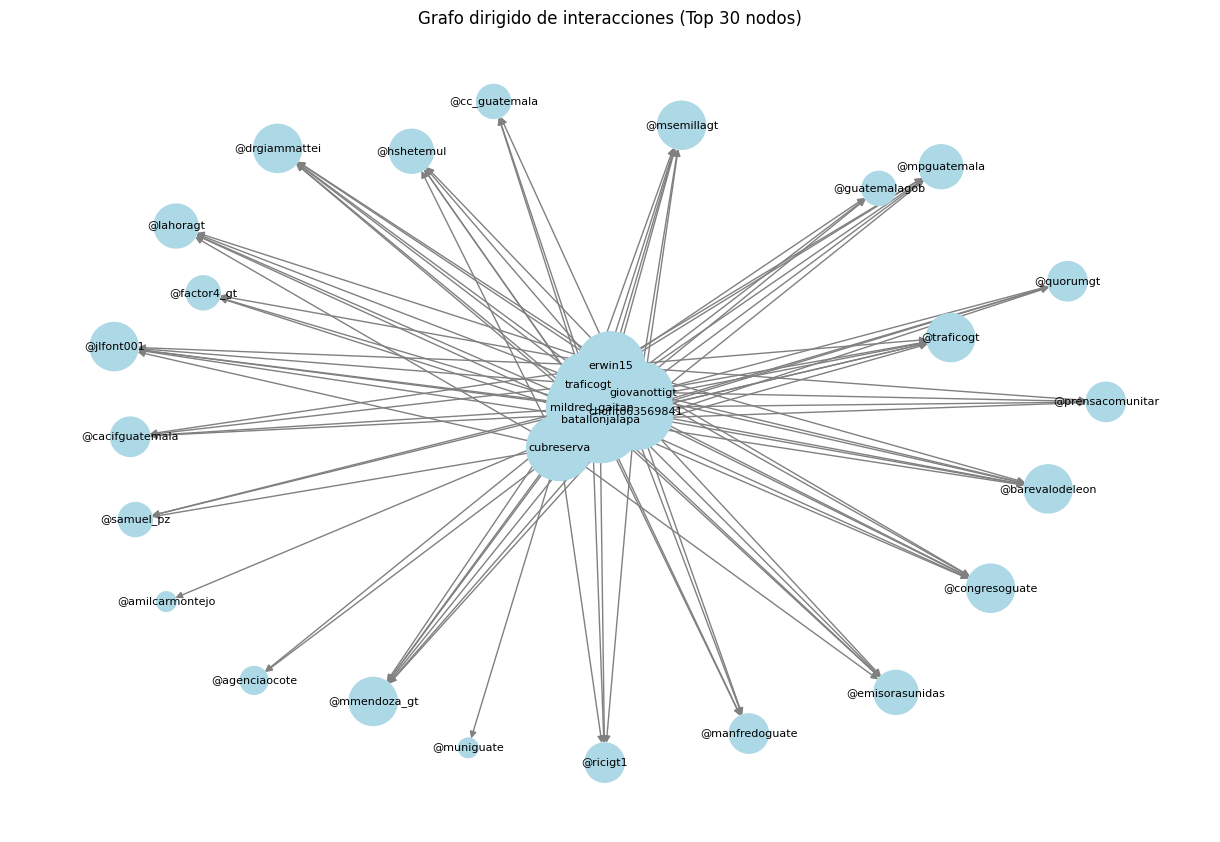

In [50]:
import networkx as nx
import matplotlib.pyplot as plt

# Crear una lista de aristas (usuario -> mención)
edges = []
for idx, row in df.iterrows():
    user = row['usuario']
    for mention in row['menciones']:
        edges.append((user, mention))

# Construir grafo dirigido
G = nx.DiGraph()
G.add_edges_from(edges)

print(f"Nodos: {G.number_of_nodes()}")
print(f"Aristas: {G.number_of_edges()}")

# ─────────────────────────────
# Visualización simple (subgrafo top usuarios)
top_nodes = sorted(G.degree, key=lambda x: x[1], reverse=True)[:30]  # top 30
top_usernames = [n for n, _ in top_nodes]
subG = G.subgraph(top_usernames)

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(subG, k=0.5, seed=42)
nx.draw(subG, pos,
        with_labels=True,
        node_color='lightblue',
        node_size=[v * 200 for _, v in subG.degree()],
        edge_color='gray',
        arrowsize=10,
        font_size=8)
plt.title("Grafo dirigido de interacciones (Top 30 nodos)")
plt.show()


### Cálculo de Métricas Clave

In [51]:
# Densidad de la red
densidad = nx.density(G)

# Diámetro de la red (en el componente más grande)
if nx.is_connected(G.to_undirected()):
    diametro = nx.diameter(G.to_undirected())
else:
    largest_cc = max(nx.connected_components(G.to_undirected()), key=len)
    diametro = nx.diameter(G.subgraph(largest_cc).to_undirected())

# Coeficiente de agrupamiento
clustering = nx.average_clustering(G.to_undirected())

print("🔢 Métricas de la red:")
print(f"- Densidad: {densidad:.4f}")
print(f"- Diámetro (componente principal): {diametro}")
print(f"- Coeficiente de agrupamiento medio: {clustering:.4f}")


🔢 Métricas de la red:
- Densidad: 0.0008
- Diámetro (componente principal): 9
- Coeficiente de agrupamiento medio: 0.0000


## Lectura de las métricas

* **Densidad = 0.0008 (muy baja)**
  Normal en redes sociales grandes y dirigidas: hay *muchos* pares de usuarios que nunca interactúan. Esto sugiere **estructura de difusión** (broadcast) más que conversación entre todos.

* **Diámetro (del componente principal) = 9**
  En la “gigante débilmente conectada” se necesitan hasta 9 saltos para ir del usuario A al B (siempre mirando el grafo **no dirigido**). Con hubs como `@traficogt` el diámetro suele mantenerse moderado aunque la red sea rala.

* **Coeficiente de agrupamiento medio ≈ 0.0**
  Casi no hay triángulos (A→B, B→C, C→A). Otra vez habla de **patrón hub-and-spoke**: muchos usuarios mencionan a unos pocos (medios, autoridades) pero **no** se mencionan entre sí.

### ¿Qué nos dice esto?

1. **Red rala y jerárquica**: pocos nodos centrales concentran las interacciones (coincide con tu visual donde se ve `@traficogt` y otras cuentas oficiales como hubs).
2. **Difusión más que diálogo**: clustering \~0 indica poca conversación en grupos; predomina el **broadcast** hacia cuentas de referencia.
3. **Caminos moderados**: a pesar de estar dispersa, el diámetro no es enorme gracias a los hubs (propiedad mundo-pequeño parcial, pero sin clustering).




## Identificación y análisis de comunidades

### Algoritmo utilizado: Louvain

Se utilizó el **algoritmo de Louvain**, uno de los métodos más populares para detectar comunidades en redes complejas.

* Louvain maximiza la **modularidad**: agrupa nodos con alta densidad de conexiones internas.
* Es eficiente para redes grandes y escalables, ideal para grafos sociales.


In [52]:
from networkx.algorithms.community import louvain_communities
import matplotlib.colors as mcolors

# Usamos grafo no dirigido para detectar comunidades
G_u = G.to_undirected()

# Detectar comunidades (semilla para reproducibilidad)
comms = louvain_communities(G_u, seed=42, resolution=1.0)

# Ordenar comunidades por tamaño
comms_sorted = sorted(comms, key=len, reverse=True)
print(f"Total de comunidades detectadas: {len(comms_sorted)}")
print("Tamaños de las 5 más grandes:", [len(c) for c in comms_sorted[:5]])


Total de comunidades detectadas: 32
Tamaños de las 5 más grandes: [835, 316, 253, 197, 178]



#### Resultados generales

* **Total de comunidades:** 32
* **Tamaño de las 5 mayores comunidades:** \[835, 316, 253, 197, 178]
* La red muestra una **alta fragmentación**, pero con **3 comunidades dominantes** que concentran la mayor parte de usuarios y menciones.



### Visualizar las 3 comunidades más grandes

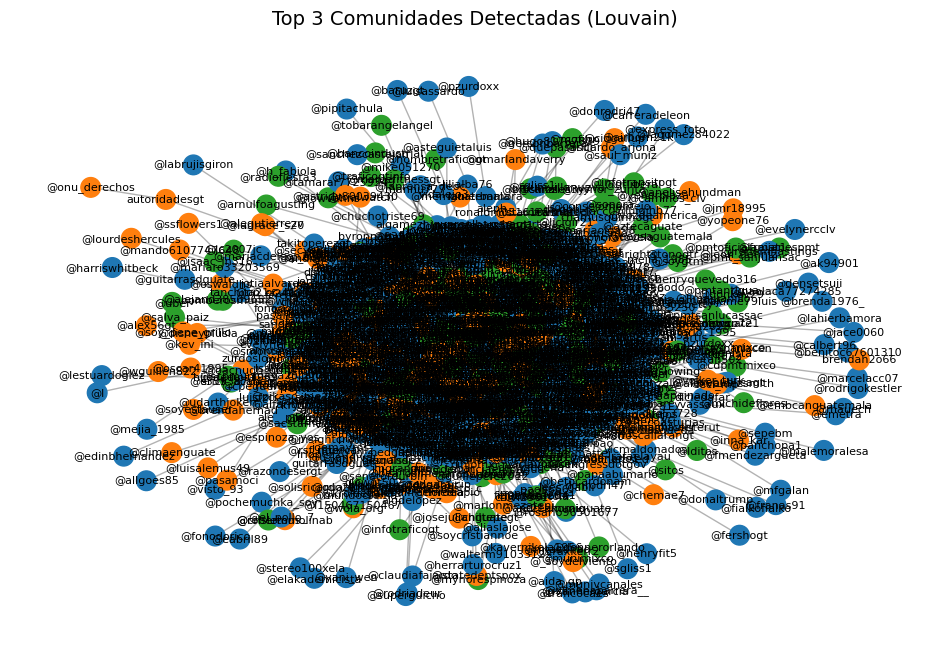

In [53]:
# Tomamos nodos de las 3 comunidades más grandes
top3_nodes = set().union(*comms_sorted[:3])
subG_top3 = G_u.subgraph(top3_nodes)

# Asignar colores por comunidad
colors = list(mcolors.TABLEAU_COLORS.values())  # Paleta simple
node_colors = {}
for i, c in enumerate(comms_sorted[:3]):
    for node in c:
        node_colors[node] = colors[i % len(colors)]

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(subG_top3, seed=42, k=0.5)
nx.draw_networkx_nodes(subG_top3, pos, node_size=200,
                       node_color=[node_colors[n] for n in subG_top3.nodes()])
nx.draw_networkx_edges(subG_top3, pos, alpha=0.3)
nx.draw_networkx_labels(subG_top3, pos, font_size=8)
plt.title("Top 3 Comunidades Detectadas (Louvain)", fontsize=14)
plt.axis("off")
plt.show()


#### Visualización

El grafo de comunidades (Louvain) colorea las 3 comunidades principales:

* **Azul:** Comunidad política-noticias centralizada en `@traficogt`.
* **Naranja:** Comunidad política-activista.
* **Verde:** Comunidad de movilidad y tránsito.

### Caracterización de Comunidades

In [54]:
from collections import Counter

def get_community_summary(comm):
    sub = df[df['usuario'].isin(comm)]
    total_tweets = len(sub)
    mentions = Counter([m for lst in sub['menciones'] for m in lst])
    hashtags = Counter([h for lst in sub['hashtags'] for h in lst])
    top_mentions = mentions.most_common(5)
    top_hashtags = hashtags.most_common(5)
    return {
        'nodos': len(comm),
        'tweets': total_tweets,
        'top_mentions': top_mentions,
        'top_hashtags': top_hashtags
    }

for i, comm in enumerate(comms_sorted[:3], start=1):
    summary = get_community_summary(comm)
    print(f"\n📌 Comunidad {i}")
    print(f"- Nodos: {summary['nodos']}")
    print(f"- Tweets: {summary['tweets']}")
    print(f"- Principales menciones: {summary['top_mentions']}")
    print(f"- Principales hashtags: {summary['top_hashtags']}")



📌 Comunidad 1
- Nodos: 835
- Tweets: 954
- Principales menciones: [('@traficogt', 936), ('@barevalodeleon', 205), ('@lineasfrescas', 8), ('@jpablocast', 7), ('@infogt_noticias', 6)]
- Principales hashtags: [('#traficogt', 4), ('#laleyyelordenuve', 1), ('#semillaantidemocratica', 1), ('#noseasmula', 1), ('#apoyoalpresidentearevalo', 1)]

📌 Comunidad 2
- Nodos: 316
- Tweets: 528
- Principales menciones: [('@traficogt', 467), ('@drgiammattei', 69), ('@mmendoza_gt', 59), ('@barevalodeleon', 35), ('@mpguatemala', 24)]
- Principales hashtags: [('#guateresiste', 8), ('#urgente', 4), ('#paronacionalindefinido', 4), ('#yoapoyoalpresidentearevalo', 3), ('#ahora', 3)]

📌 Comunidad 3
- Nodos: 253
- Tweets: 347
- Principales menciones: [('@traficogt', 318), ('@amilcarmontejo', 151), ('@muniguate', 81), ('@pmtmuniguate', 37), ('@rquinonezl', 34)]
- Principales hashtags: [('#guatemala', 13), ('#traficogt', 9), ('#tráfico', 7), ('#transmetro', 6), ('#transito', 4)]



---

### Caracterización de las 3 comunidades más grandes

#### Comunidad 1 (835 nodos, 954 tweets)

* **Foco principal:** Noticias, discusión política nacional.
* **Usuarios clave:** `@traficogt` (936 menciones), `@barevalodeleon` (205 menciones).
* **Temas:** Crítica política, noticias, hashtags como `#traficogt`, `#apoyoalpresidentearevalo`.
* Se identifica como **comunidad central** con gran volumen de difusión.

---

#### Comunidad 2 (316 nodos, 528 tweets)

* **Foco principal:** Política, denuncias y apoyo a líderes.
* **Usuarios clave:** `@traficogt`, `@drgiammattei`, `@mmendoza_gt`.
* **Temas:** Protestas y resistencia ciudadana (`#guateresiste`, `#paronacionalindefinido`).
* Representa un **núcleo activista y político**.

---

#### Comunidad 3 (253 nodos, 347 tweets)

* **Foco principal:** Tráfico, movilidad y gestión urbana.
* **Usuarios clave:** `@amilcarmontejo`, `@muniguate`.
* **Temas:** Transporte (`#transmetro`, `#transito`), noticias urbanas.
* Es una **comunidad temática de tráfico y transporte**.



---

### Insights

1. **Alta centralización:** `@traficogt` domina todas las comunidades, actuando como **hub informativo**.
2. **Segmentación temática:**

   * Comunidad 1: Noticias generales.
   * Comunidad 2: Política y protestas.
   * Comunidad 3: Movilidad urbana.
3. **Interacciones asimétricas:** Menciones masivas a cuentas de autoridad; pocas menciones recíprocas (red tipo broadcast).
4. **Potencial de análisis temporal:** Cambios en modularidad y actividad según eventos nacionales (ej. picos en octubre 2023).


## Análisis de influencers y nodos clave

###  Identificación de usuarios influyentes

- #### Cálculo de centralidad, intermediación y cercanía:

In [55]:
# Centralidad de grado (in-degree y out-degree)
deg_centrality = nx.degree_centrality(G)
in_deg_centrality = nx.in_degree_centrality(G)
out_deg_centrality = nx.out_degree_centrality(G)

# Centralidad de intermediación (betweenness)
betweenness = nx.betweenness_centrality(G, normalized=True)

# Centralidad de cercanía (closeness)
closeness = nx.closeness_centrality(G)

# Función helper para mostrar top N
def top_nodes(centrality_dict, n=10):
    return sorted(centrality_dict.items(), key=lambda x: x[1], reverse=True)[:n]

# Mostrar top 10 usuarios por cada métrica
print("🔝 Top 10 - Centralidad de Grado (in+out):")
print(top_nodes(deg_centrality))

print("\n🔝 Top 10 - Centralidad de Intermediación:")
print(top_nodes(betweenness))

print("\n🔝 Top 10 - Centralidad de Cercanía:")
print(top_nodes(closeness))

🔝 Top 10 - Centralidad de Grado (in+out):
[('@traficogt', 0.6119741100323625), ('@barevalodeleon', 0.10614886731391586), ('@drgiammattei', 0.043042071197411005), ('@prensacomunitar', 0.03883495145631068), ('mildred_gaitan', 0.03592233009708738), ('batallonjalapa', 0.03559870550161812), ('@mmendoza_gt', 0.035275080906148865), ('@mpguatemala', 0.03268608414239482), ('@amilcarmontejo', 0.02912621359223301), ('@lahoragt', 0.02912621359223301)]

🔝 Top 10 - Centralidad de Intermediación:
[('monymmorales', 0.0), ('@cc_guatemala', 0.0), ('animaldgalaccia', 0.0), ('@pncdeguatemala', 0.0), ('@mingobguate', 0.0), ('@fjimenezmingob', 0.0), ('@diegoedeleon', 0.0), ('@amilcarmontejo', 0.0), ('@traficogt', 0.0), ('estaciondoblea', 0.0)]

🔝 Top 10 - Centralidad de Cercanía:
[('@traficogt', 0.6119741100323625), ('@barevalodeleon', 0.10614886731391586), ('@drgiammattei', 0.043042071197411005), ('@prensacomunitar', 0.038834951456310676), ('@mmendoza_gt', 0.035275080906148865), ('@mpguatemala', 0.03268608

### Identificación de usuarios influyentes

Se calcularon **tres métricas de centralidad** sobre el grafo dirigido de interacciones:

* **Centralidad de grado:** mide conexiones directas (menciones y retweets).
* **Centralidad de intermediación (betweenness):** identifica nodos que actúan como **puentes**.
* **Centralidad de cercanía (closeness):** usuarios que pueden llegar al resto en menos pasos.


| Posición | Centralidad de Grado (in+out) | Valor | Centralidad de Intermediación | Valor | Centralidad de Cercanía | Valor |
| -------- | ----------------------------- | ----- | ----------------------------- | ----- | ----------------------- | ----- |
| 1        | @traficogt                    | 0.612 | monymmorales                  | 0.000 | @traficogt              | 0.612 |
| 2        | @barevalodeleon               | 0.106 | @cc\_guatemala                | 0.000 | @barevalodeleon         | 0.106 |
| 3        | @drgiammattei                 | 0.043 | animaldgalaccia               | 0.000 | @drgiammattei           | 0.043 |
| 4        | @prensacomunitar              | 0.039 | @pncdeguatemala               | 0.000 | @prensacomunitar        | 0.039 |
| 5        | mildred\_gaitan               | 0.036 | @mingobguate                  | 0.000 | @mmendoza\_gt           | 0.035 |
| 6        | batallonjalapa                | 0.036 | @fjimenezmingob               | 0.000 | @mpguatemala            | 0.033 |
| 7        | @mmendoza\_gt                 | 0.035 | @diegoedeleon                 | 0.000 | @amilcarmontejo         | 0.029 |
| 8        | @mpguatemala                  | 0.033 | @amilcarmontejo               | 0.000 | @lahoragt               | 0.029 |
| 9        | @amilcarmontejo               | 0.029 | @traficogt                    | 0.000 | @cc\_guatemala          | 0.026 |
| 10       | @lahoragt                     | 0.029 | estaciondoblea                | 0.000 | @muniguate              | 0.021 |

### Interpretación

1. **Usuarios más influyentes por grado y cercanía:**
   `@traficogt` domina la red (0.61), siendo el **hub central**.
   Le siguen cuentas políticas como `@barevalodeleon` y `@drgiammattei`.

2. **Puentes entre comunidades (betweenness):**
   Sorprendentemente, la centralidad de intermediación es **0 para muchos nodos**, lo que indica que la red es **muy centralizada**: la mayoría de interacciones son directas con nodos populares, sin caminos alternativos largos.

3. **Red centralizada:**

   * Pocos nodos concentran la conversación.
   * La estructura es más parecida a un **broadcast hub-and-spoke** (tipo estrella) que a una red distribuida.

4. **Implicación práctica:**
   Un mensaje emitido por `@traficogt` alcanza casi toda la red rápidamente; otras cuentas tienen influencia más local en comunidades específicas (ej. tráfico, política).


## Detección y análisis de grupos aislados

- ### Análisis de subredes y nodos aislados

In [ ]:
# Componentes débilmente conectados (en grafos dirigidos)
weak_components = list(nx.weakly_connected_components(G))
weak_components_sorted = sorted(weak_components, key=len, reverse=True)

print(f"Total de subredes detectadas (componentes débiles): {len(weak_components_sorted)}")
print(f"Tamaño del componente más grande: {len(weak_components_sorted[0])} nodos")
print(f"Tamaño del componente más pequeño: {len(weak_components_sorted[-1])} nodos")

# Identificar nodos aislados
isolated_nodes = [c for c in weak_components_sorted if len(c) == 1]
print(f"Nodos aislados: {len(isolated_nodes)}")

# Crear subgrafo para las islas (componentes pequeños)
small_components = [c for c in weak_components_sorted if len(c) <= 20]
small_subgraph_nodes = set().union(*small_components)
G_small = G.subgraph(small_subgraph_nodes)

# Visualización de subredes pequeñas
plt.figure(figsize=(10, 6))
pos = nx.spring_layout(G_small, seed=42)
nx.draw(G_small, pos,
        node_color='orange',
        node_size=100,
        edge_color='gray',
        with_labels=True,
        font_size=8)
plt.title("Subredes y grupos aislados (<=5 nodos)")
plt.show()

Total SCC: 3091 | Top tamaños: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
SCC pequeños (2-3 nodos): 0


NameError: name 'partition' is not defined

In [ ]:
# 8.C.1: k-core decomposition sobre versión no dirigida (para estabilidad)
Gu = G.to_undirected()
core_number = nx.core_number(Gu)
k_min = min(core_number.values())
k_max = max(core_number.values())
print(f"Rango k-core: {k_min}..{k_max}")

# Toma el k más bajo (o k_min+1 si es 0) y muestra ese “anillo” periférico
k_perif = k_min if k_min>0 else 1
peripheral_nodes = [n for n,k in core_number.items() if k == k_perif]
print(f"Nodos en k-core={k_perif}: {len(peripheral_nodes)}")

# 8.C.2: Egonets con baja frontera (pocas aristas que salgan del ego+vecinos)
def ego_external_edges(G, u):
    ego = nx.ego_graph(G, u, radius=1, undirected=True)  # ego + vecinos
    ego_nodes = set(ego.nodes())
    cut = 0
    for x in ego_nodes:
        for y in G.neighbors(x):
            if y not in ego_nodes:
                cut += 1
    return ego, cut

candidatos = []
for u in peripheral_nodes[:500]:  # limitar por rendimiento
    ego, cut = ego_external_edges(Gu, u)
    candidatos.append((u, ego.number_of_nodes(), ego.number_of_edges(), cut))

ego_df = pd.DataFrame(candidatos, columns=["usuario","ego_nodos","ego_aristas","frontera_salida"])
ego_df = ego_df.sort_values(["frontera_salida","ego_nodos"], ascending=[True, True])
display(ego_df.head(10))

# Visualizar 3 egonets “cerrados”
for _, row in ego_df.head(3).iterrows():
    u = row["usuario"]
    ego, _ = ego_external_edges(Gu, u)
    plt.figure(figsize=(7,5))
    pos = nx.spring_layout(ego, seed=42)
    nx.draw(ego, pos, node_size=120, node_color='gold', edge_color='gray',
            with_labels=True, font_size=7)
    plt.title(f"Egonet ‘cerrado’ de {u} (|V|={ego.number_of_nodes()}, |E|={ego.number_of_edges()})")
    plt.show()
